# Simple Moving Average

- SMA calculates the average price of an asset over a specified period of time and gives equal weight to each data point.
- Calculate signal based on moving average crossover
- We will always by "in" a trade, either long or short, for this strategy

# Exponential Moving Average

- EMA gives more weight to recent price action. 
- EMA =(Close - EMA(previous day)) x Multiplier + EMA(previous day)
- The multiplier used depends on the length of the period used. For a i-day EMA, the multiplier would be 2/(i+1).
- It captures changes and trends much faster than SMA. However, it gives false signals more often than SMA.

In [1]:
# Data Handling
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

# Financial Data Analysis
import yfinance as yf
import ta
import quantstats as qs

# Hiding warnings 
import warnings
warnings.filterwarnings("ignore")

In [2]:
today = datetime.today()
start_date = today - relativedelta(months = 6)

btc = yf.download('BTC-USD', start=start_date, end=today, interval='1d')
day = np.arange(1, len(btc) + 1)
btc['day'] = day
btc = btc[['day', 'Open', 'High', 'Low', 'Adj Close']]
btc.head()

[*********************100%%**********************]  1 of 1 completed


,day,Open,High,Low,Adj Close
Date,,,,,
2024-01-09,1,46987.640625,47893.699219,45244.714844,46139.730469
2024-01-10,2,46121.539062,47647.222656,44483.152344,46627.777344
2024-01-11,3,46656.074219,48969.371094,45678.644531,46368.585938
2024-01-12,4,46354.792969,46498.136719,41903.769531,42853.167969
2024-01-13,5,42799.445312,43234.660156,42464.144531,42842.382812


In [3]:
# Fast Moving Average
num1 = 5
# Slow Moving Average
num2 = 27
btc['Fast'] = ta.trend.sma_indicator(btc['Adj Close'], window=num1).shift() # shift() here is to roll moving average forward for 1 day to avoid implied look ahead
btc['Slow'] = ta.trend.ema_indicator(btc['Adj Close'], window=num2).shift()
btc[num2-2:num2+3]

,day,Open,High,Low,Adj Close,Fast,Slow
Date,,,,,,,
2024-02-03,26,43184.964844,43359.941406,42890.808594,42992.250000,43017.018750,NaN
2024-02-04,27,42994.941406,43097.644531,42374.832031,42583.582031,42957.819531,NaN
2024-02-05,28,42577.621094,43494.250000,42264.816406,42658.667969,42884.014062,42843.142036
2024-02-06,29,42657.390625,43344.148438,42529.019531,43084.671875,42899.226562,42829.965317
2024-02-07,30,43090.019531,44341.949219,42775.957031,44318.222656,42901.006250,42848.158642


In [4]:
fig = make_subplots(rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.05)

fig.add_trace(go.Candlestick(x=btc.index,
                             open=btc['Open'],
                             high=btc['High'],
                             low=btc['Low'],
                             close=btc['Adj Close'],
                             name='BTC'))

fig.add_trace(go.Scatter(x=btc.index,
                         y=btc['Fast'],
                         mode='lines',
                         line=dict(color='yellow'),
                         name='SMA 5'))

fig.add_trace(go.Scatter(x=btc.index,
                         y=btc['Slow'],
                         mode='lines',
                         line=dict(color='green'),
                         name='EMA 27'))

fig.add_annotation(text='BTC 1D',
                    font=dict(color='white', size=40),
                    xref='paper', yref='paper',
                    x=0.5, y=0.65,
                    showarrow=False,
                    opacity=0.2)

fig.update_layout(title='BTC Daily Candlestick Chart',
                  yaxis=dict(title='Price'),
                  height=1000,
                 template = 'plotly_dark')

fig.update_xaxes(rangeslider_visible=False)
fig.show()

In [5]:
# Add "signal" column
# Long
btc['signal'] = np.where(btc['Fast'] > btc['Slow'], 1, 0)
# Short
btc['signal'] = np.where(btc['Fast'] < btc['Slow'], -1, btc['signal'])

btc['entry'] = btc.signal.diff()
btc.dropna(inplace=True)
btc.head()

,day,Open,High,Low,Adj Close,Fast,Slow,signal,entry
Date,,,,,,,,,
2024-02-05,28,42577.621094,43494.250000,42264.816406,42658.667969,42884.014062,42843.142036,1,1.0
2024-02-06,29,42657.390625,43344.148438,42529.019531,43084.671875,42899.226562,42829.965317,1,0.0
2024-02-07,30,43090.019531,44341.949219,42775.957031,44318.222656,42901.006250,42848.158642,1,0.0
2024-02-08,31,44332.125000,45575.839844,44332.125000,45301.566406,43127.478906,42953.163215,1,0.0
2024-02-09,32,45297.382812,48152.496094,45260.824219,47147.199219,43589.342187,43120.906300,1,0.0


In [6]:
# Calculating the total returns
btc['returns'] = btc['Adj Close'].pct_change()
btc['cumulative_returns'] = (1 + btc['returns']).cumprod() - 1

# Applying the signals to the returns
btc['strategy_returns'] = btc['signal'] * btc['returns']

# Calculate the cumulative returns
btc['cumulative_strategy_returns'] = (1 + btc['strategy_returns']).cumprod() - 1

# Backtesting

In [7]:
# Setting the initial capital
initial_capital = 100000

# Calculating the total portfolio value
btc['portfolio_value'] = (1 + btc['strategy_returns']).cumprod() * initial_capital

# Printing the number of trades, initial capital, and final capital
num_trades = btc[abs(btc['entry']) == 2].shape[0]
final_capital = btc['portfolio_value'].iloc[-1]
total_return = (final_capital - initial_capital) / initial_capital * 100

print('\n')
print(f"Number of trades: {num_trades}")
print(f"Initial capital: ${initial_capital}")
print(f"Final capital: ${final_capital:.2f}")
print(f"Total return: {total_return:.2f}%")
print('\n')

# Plotting strategy portfolio 
fig = go.Figure()

fig.add_trace(go.Scatter(x=btc.index,
                         y=btc['portfolio_value'].round(2),
                         mode='lines',
                         line=dict(color='#00BFFF'),
                         name='Portfolio Value'))

fig.update_layout(title='Portfolio - Moving Average Crossover Strategy on Daily Data',
                  xaxis_title='Date',
                  yaxis_title='Value ($)',
                  template='plotly_dark',
                 height = 600)

fig.show()



Number of trades: 3
Initial capital: $100000
Final capital: $176158.21
Total return: 76.16%




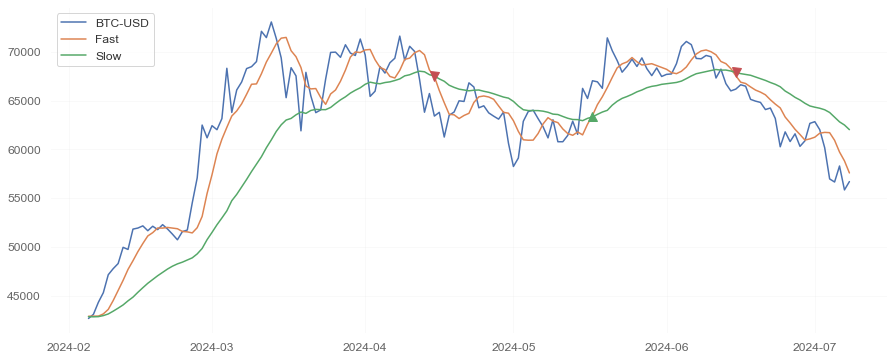

In [8]:
# Plot trades on time series
plt.rcParams['figure.figsize'] = 15, 6
plt.grid(True, alpha = .3)
plt.plot(btc.iloc[:]['Adj Close'], label = 'BTC-USD')
plt.plot(btc.iloc[:]['Fast'], label = 'Fast')
plt.plot(btc.iloc[:]['Slow'], label = 'Slow')
plt.plot(btc[:].loc[btc.entry == 2].index, btc[:]['Fast'][btc.entry == 2], '^',
         color = 'g', markersize = 9)
plt.plot(btc[:].loc[btc.entry == -2].index, btc[:]['Slow'][btc.entry == -2], 'v',
         color = 'r', markersize = 9)
plt.legend(loc=2);

# Compare to buy and hold strategy

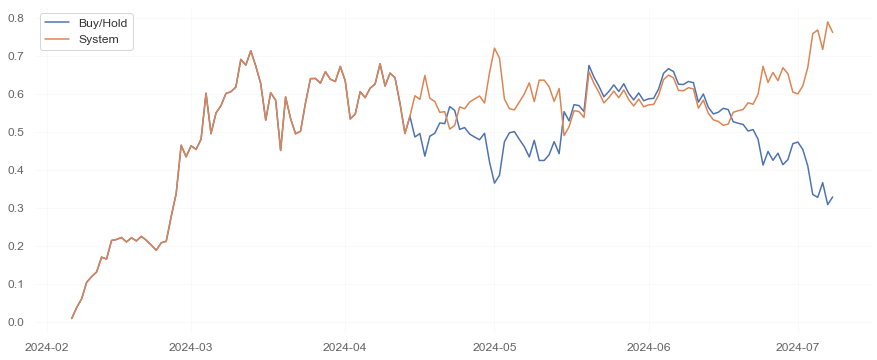

In [12]:
plt.plot(btc['cumulative_returns'], label='Buy/Hold')
plt.plot(btc['cumulative_strategy_returns'], label='System')

plt.legend(loc=2)
plt.grid(True, alpha=.3)